## **Settings**

- Importing all necessary libraries and modules.

In [1]:
import os, sys, random
from sys import platform
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
import numpy as np
from monai.utils import set_determinism
from src.helpers.utils import make_dataset, get_device
import src.modules.plotting as plot
from src.modules.training import train_test_splitting, training_model, predict_ae
from src.helpers.config import get_config
from src.modules.preprocessing import get_transformations
from src.models.autoencoder3d import AutoEncoder3D
from src.helpers.graph import image_to_graph

- Definition of paths.

In [2]:
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	data_path = data_path.replace('/', '\\')
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')

- Ensure reproducibility by setting a seed.

In [3]:
set_determinism(seed=3)
random.seed(3)

- Download of the dataset and splitting in **training**, **evalulation** and **testing** sets.

**NOTES**:

1. The download will start if data are not already present in `data` folder. A valid Synapse authentication token is required in `.env` file.

2. The splitting is carried out on subjects and not on sessions to avoid data leakage problem.

In [4]:
data_folder = make_dataset(dataset='glioma', verbose=False)
# data_folder = os.path.join(data_path, 'tumor-mix', 'BraTS-PDGM')
train_data, eval_data, test_data = train_test_splitting(data_folder, reports_path=reports_path, load_from_file=True)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            798 (63.79 %)       201 (16.07 %)       252 (20.14 %)       



- Definition of images preprocessing pipelines.

**NOTES**:

1. Only for training set random distortions such as flippings and rotations are applied.

In [5]:
(
	base_image_transform,
	autoencoder_train_transform,
	autoencoder_eval_transform,
	_, _
) = get_transformations()

- Graph of a dataset entry before and after the preprocessing pipeline. All MRI-channels are sliced on Z-axis. 

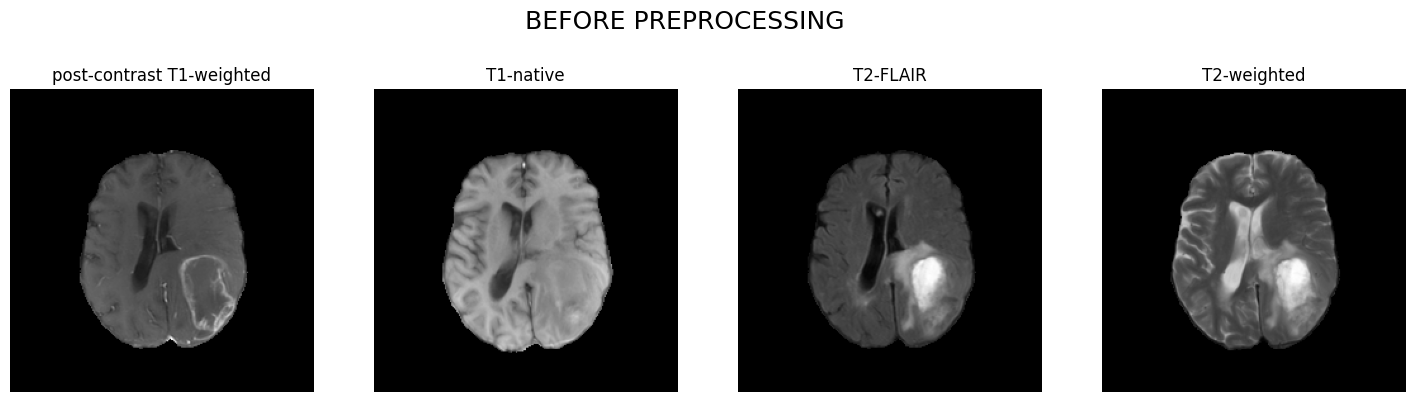

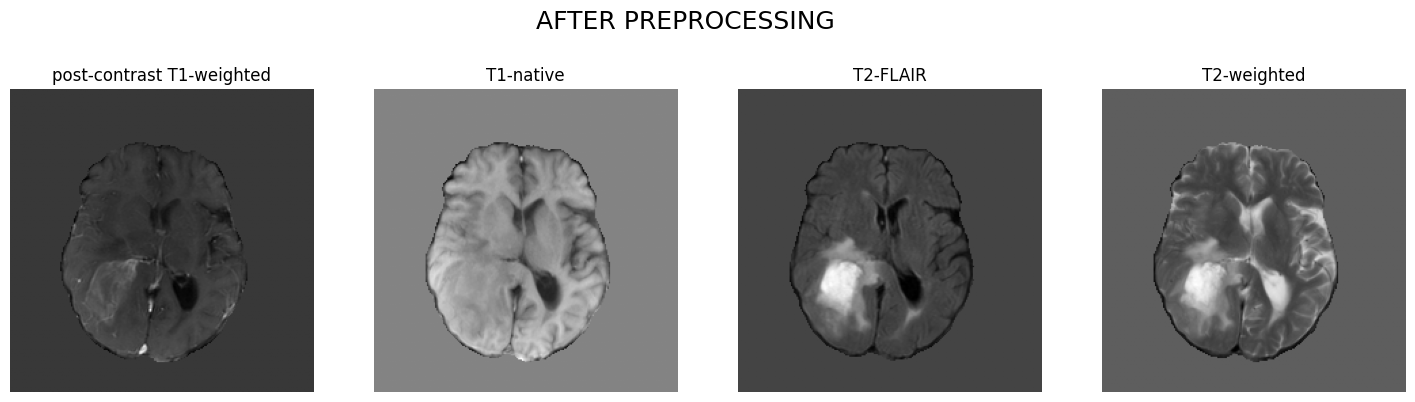

In [6]:
before = train_data[3]
after = autoencoder_train_transform(before)
plot.before_after(
	before['image'],
	after['image'],
	titles=['BEFORE PREPROCESSING', 'AFTER PREPROCESSING']
)

## **Training AutoEncoder3D**

- Definition of the **AutoEncoder3D** model to extract latent features representation to be appended to graph nodes.

In [6]:
model = AutoEncoder3D(
	spatial_dims=3,
	in_channels=4,
	out_channels=4,
	channels=(5,),
	strides=(2,),
	inter_channels=(8, 8, 16),
	inter_dilations=(1, 2, 4)
)

- Execution of the training phase.

In [8]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = model,
# 	data = [train_data[:10], eval_data[:4]],
# 	transforms = [autoencoder_train_transform, autoencoder_eval_transform],
# 	epochs = 10,
# 	device = 'cpu', # get_device(), # 'mps' not supported
# 	paths = [saved_path, reports_path, logs_path, ''],
# 	num_workers=0,
# 	verbose = True
# )

- Plot of the losses (to the left) and the scores (to the right) during the execution of the training phase. Three different metric has been calculated:

	- **Structural Similarity Index Metric (SSIM)**.

	- **Peak Signal-to-Noise Ration (PSNR)**.

	- **Normalized Cross-Correlation (NCC)**.


**NOTES**:

1. The verical red line indicates the best run according to the application of early stopping technique.

2. The **SSIM** has been considered to apply the early stopping.

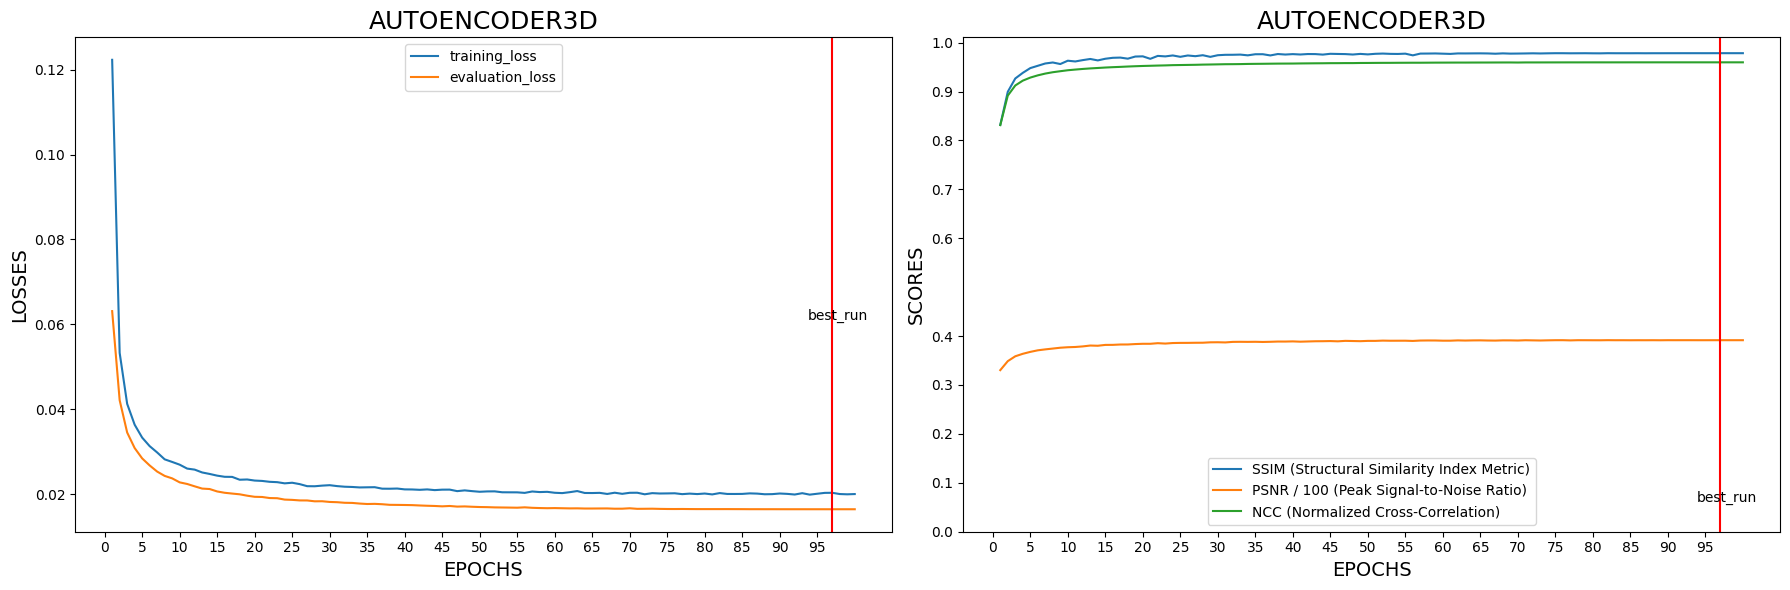

In [8]:
plot.training_values(reports_path, ['AUTOENCODER3D_1738574929'])

- Execution of the testing phase.

**NOTES**:

1. The metrics has been pre-saved for velocity purposes.


In [10]:
## NOTE: uncomment to execute the prediction on the testing set.

ssim, psnr, ncc = [0.9789], [39.8070], [0.9631]
# ssim, psnr, ncc = [], [], []
# for _, d in enumerate(test_data):
# 	_, _, m = predict_ae(
# 		model = model,
# 		data = d,
# 		transforms = autoencoder_eval_transform,
# 		device = 'cpu', # get_device(), # 'mps' not supported
# 		saved_path = saved_path
# 	)
# 	ssim.append(m[0]), psnr.append(m[1]), ncc.append(m[2])
print(''.join(['> ' for i in range(40)]))
print(f'\n{"":<20}{"SSIM (avg)":<15}{"PSNR (avg)":<15}{"NCC (avg)":<15}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"AutoEncoder3D":<20}{np.mean(ssim):<15.4f}{np.mean(psnr):<15.4f}{np.mean(ncc):<15.4f}')
print(''.join(['> ' for i in range(40)]))

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    SSIM (avg)     PSNR (avg)     NCC (avg)      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
AutoEncoder3D       0.9789         39.8070        0.9631         
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


- Graph of a test set entry and the relative AutoEncoder3D reconstructed image. All MRI-channels are sliced on Z-axis. 

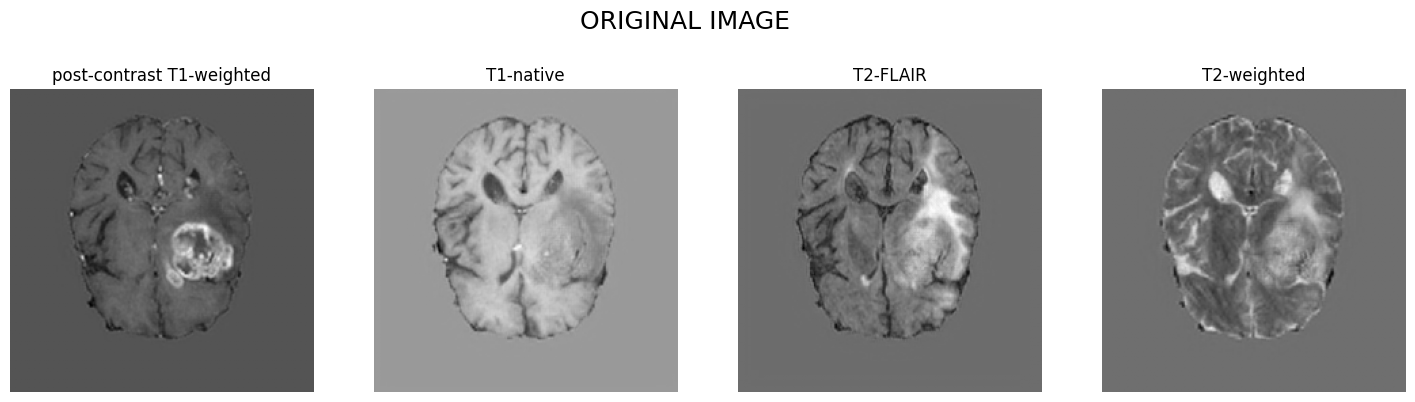

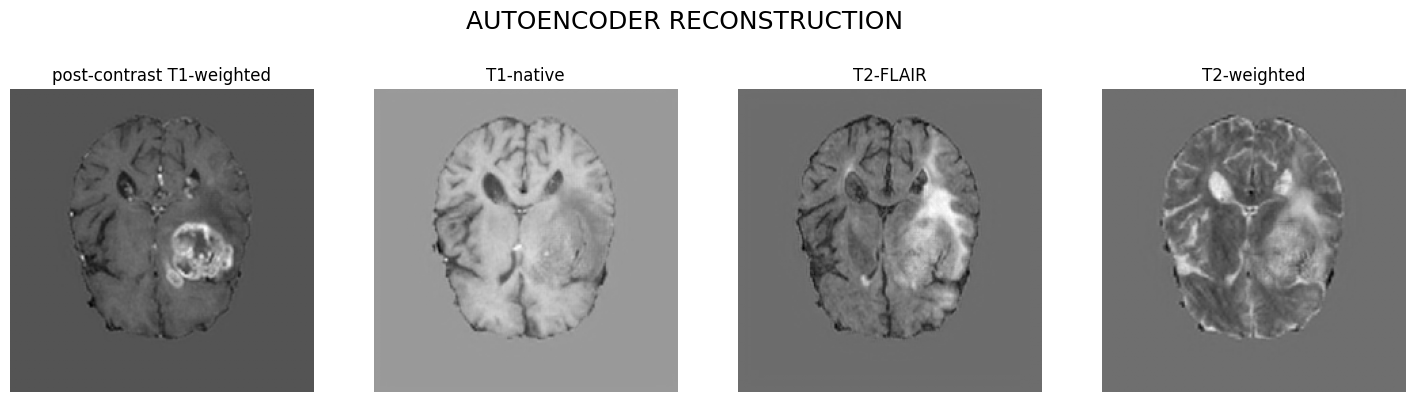

In [11]:
reconstructed, _, _ = predict_ae(
	model = model,
	data = test_data[0],
	transforms = autoencoder_eval_transform,
	device = 'cpu', # get_device(), # 'mps' not supported
	saved_path = saved_path
)
trans_test_data = autoencoder_eval_transform(test_data[0])
plot.before_after(
	trans_test_data['image'],
	reconstructed,
	titles=['ORIGINAL IMAGE', 'AUTOENCODER RECONSTRUCTION']
)

## **Graph construction**

- From MRI to graph.

In [18]:
graph, centroids = image_to_graph(
	data = test_data[0], # from glioma dataset
	n_segments = 5000,
	# model = model,
	# saved_path = saved_path,
	# write_to_file = data_path
)
print(graph)

Data(x=[1064, 20], edge_index=[2, 10640], y=[1064])


- Plotting of a 3D static and interactive version of a graph data entry

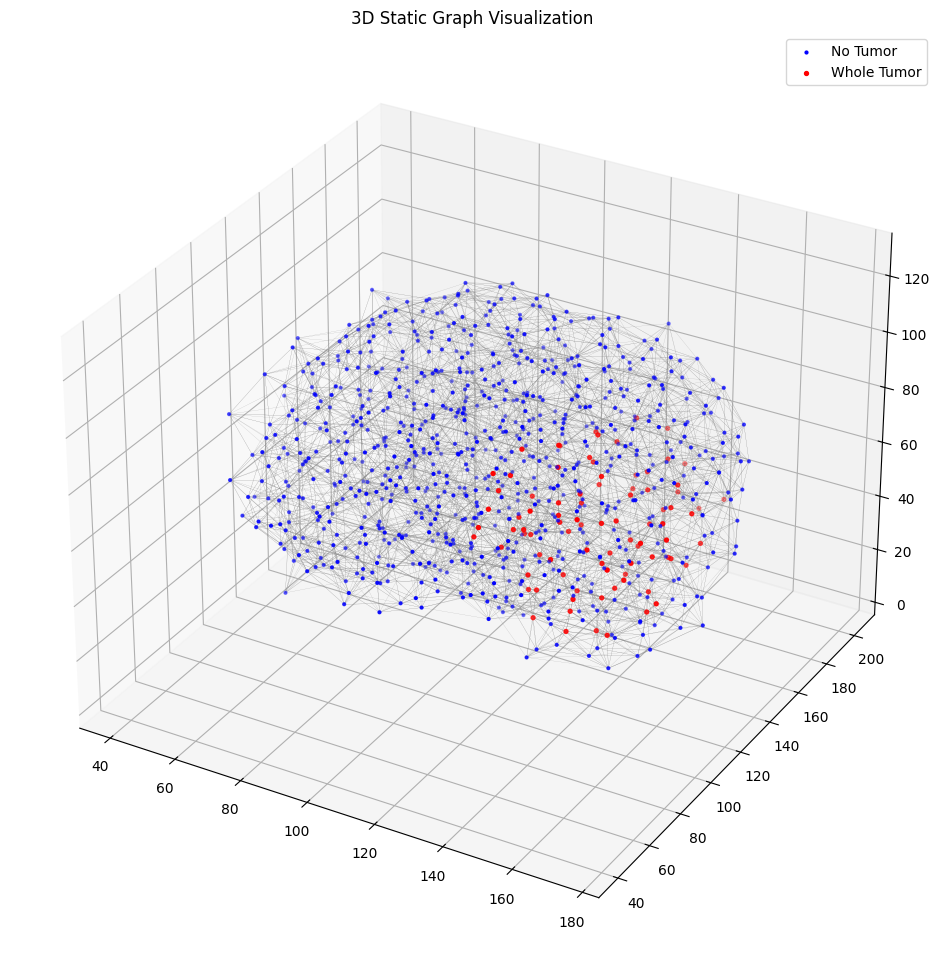

In [8]:
plot.graph(graph, centroids)